In [153]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from scipy import sparse
from scipy.sparse import csgraph

In [247]:
mutinf_df = pd.read_csv('/home/fatemeh/projects/mantis2/mantis/newOrder3.out.mutinfo', sep='\t', header=None)
mutinf_df.columns = ['i', 'j', 'mutinf']

In [248]:
dist_df = pd.read_csv('/home/fatemeh/projects/mantis2/mantis/newOrder3.out', sep='\t', header=None)
dist_df.columns = ['i', 'j', 'dist']

# Side To Side Approach

Input : D (distance matrix n-by-n) and X ().

1. Set X0 = X, t = 0, define P−1 = In×n.

2. Calculate St = DXt.

3. Find Pt which sorts St in a descending order.

4. If PtSt ≠ Pt−1St, set Xt+1 = PtTX0, set t = t + 1 and go to 2.

5. Output PtDPtT.

In [429]:
def sts(dist, n):
    p = np.identity(n)
    x0 = np.matrix([[(i - (n + 1)/2)] for i in range(n)])
    x = x0
    prevp = np.identity(n)
    cntr = 0
    while True:
        cntr += 1
        s = dist*x
        sidx = np.argsort(s.flatten())
        p = np.zeros( (n,n) )
        for i in range(n):
            p[n-i-1][sidx[0,i]] = 1
        if np.array_equal(p*s, prevp*s):
            break
        x = p.transpose()*x0
        prevp = p
        if cntr % 100 == 0:
            print("{} iterations passed ..".format(cntr), end='\r', flush=True),
    print('{} iterations'.format(cntr))
    return np.nonzero(p)[1], np.matmul(np.matmul(p,dist),p.transpose())

## Inverted Mutual Information Matrix

In [389]:
n = 2586
eps = 0.000001
mutinf_recip = np.zeros([n, n])
for idx, row in mutinf_df.iterrows():
    mutinf_recip[int(row['i']), int(row['j'])] = 1/(row['mutinf']+eps)

In [417]:
mutinf_p, mutinf_reordered_dist = sts(mutinf_recip, 2586)

16 iterations


## Hamming Distance Matrix

In [284]:
n = 2586
ham_dist = np.zeros([n, n])
for idx, row in dist_df.iterrows():
    ham_dist[row['i'], row['j']] = row['dist']

In [418]:
ham_p, ham_reordered_dist = sts(ham_dist, 2586)

12 iterations


## Inverted Hamming Distance Matrix

In [412]:
def invertMat(x):
    return 1/(eps+x)
invertMat = np.vectorize(invertMat, otypes=[np.float])
inverted_ham_dist = invertMat(ham_dist)

In [421]:
inverted_ham_dist

array([[  1.00000000e+06,   5.47915183e-05,   5.58035714e-05, ...,
          2.70826563e-05,   2.50413182e-05,   5.66893424e-05],
       [  5.47915183e-05,   1.00000000e+06,   1.01905635e-04, ...,
          3.44056425e-05,   2.49756487e-05,   1.02658865e-04],
       [  5.58035714e-05,   1.01905635e-04,   1.00000000e+06, ...,
          3.46596423e-05,   2.45507218e-05,   1.08038029e-04],
       ..., 
       [  2.70826563e-05,   3.44056425e-05,   3.46596423e-05, ...,
          1.00000000e+06,   1.83587296e-05,   3.63609919e-05],
       [  2.50413182e-05,   2.49756487e-05,   2.45507218e-05, ...,
          1.83587296e-05,   1.00000000e+06,   2.70343336e-05],
       [  5.66893424e-05,   1.02658865e-04,   1.08038029e-04, ...,
          3.63609919e-05,   2.70343336e-05,   1.00000000e+06]])

In [ ]:
inverted_ham_p, inverted_ham_reordered_dist = sts(inverted_ham_dist, 2586)

## Sample 4-by-4 Matrix

In [419]:
n = 4
sample_dist = np.matrix([[0,4,3,1], [4,0,1,3], [3,1,0,2], [1,3,2,0]])
sample_p, sampe_reordered_dist = sts(sample_dist, n)

2 iterations


# STS : Results and Plots

In [411]:
np.savetxt('/home/fatemeh/projects/mantis2/mantis/sts_mutinf_newOrder.out', mutinf_p, delimiter='\t', fmt='%d')

# Hamming Distance
## Original

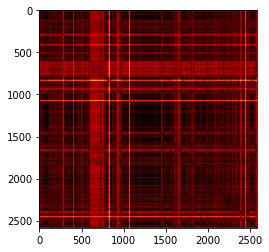

In [381]:
plt.imshow(dist, cmap='hot', interpolation='nearest')
plt.show()

# Reordered

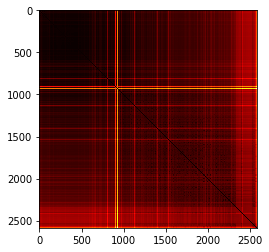

In [404]:
plt.imshow(ham_reordered_dist, cmap='hot', interpolation='nearest')
plt.show()

# Inverted Mutual Information
## Original

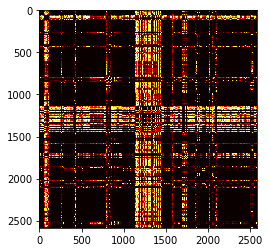

In [414]:
plt.imshow(mutinf_recip, cmap='hot', interpolation='nearest')
plt.show()

## Reordered

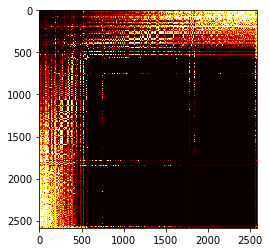

In [398]:
plt.imshow(mutinf_reordered_dist, cmap='hot', interpolation='nearest')
plt.show()

# Neighborhood

In [11]:
sigma = 1
w = np.matrix([[np.exp((-1*(i-j)**2)/(n*sigma)) for i in range(n)] for j in range(n)])

In [12]:
w

matrix([[ 1.        ,  0.71653131,  0.26359714],
        [ 0.71653131,  1.        ,  0.71653131],
        [ 0.26359714,  0.71653131,  1.        ]])

In [13]:
w.transpose()

matrix([[ 1.        ,  0.71653131,  0.26359714],
        [ 0.71653131,  1.        ,  0.71653131],
        [ 0.26359714,  0.71653131,  1.        ]])

In [15]:
m=dist*w

In [21]:
df = pd.read_csv('/home/fatemeh/projects/mantis2/mantis/edit.dist', sep='\t')
df.head()
df.columns = ['i', 'j', 'd']

In [25]:
print(df.d.min())
print(df.d.max())

9127650.0
120401000.0


In [ ]:
#df.sort_values(['d']).d.unique()

# Cuthill Mckee

In [300]:
print('mutinfo mean: {}'.format(mutinf_df.mutinf.mean()))
print('mutinfo median: {}'.format(mutinf_df.mutinf.median()))
print('hamming dist mean: {}'.format(dist_df.dist.mean()))
print('hamming dist median: {}'.format(dist_df.dist.median()))

mutinfo mean: 0.009691046269140824
mutinfo median: 0.00140579
hamming dist mean: 24214.566500348104
hamming dist median: 19622.0


In [216]:
res = pd.merge(mutinf_df, dist_df, on = ['i', 'j'], how='inner')

In [255]:
def thresh_filter(row):
    if row['mutinf'] >= 0.01:
        return 1
    return 0
mutinf_df['adj'] = mutinf_df.apply(thresh_filter, axis=1)

In [249]:
def thresh_filter(row):
    if row['dist'] >= 0.003:
        return 1
    return 0
dist_df['adj'] = dist_df.apply(thresh_filter, axis=1)

In [252]:
sim = sparse.csr_matrix((mutinf_df.adj, (mutinf_df.i, mutinf_df.j)))

In [253]:
newOrder = csgraph.reverse_cuthill_mckee(sim, symmetric_mode=True)

In [257]:
newOrder[0:10]

array([1336, 1319, 2585, 2584, 2583, 2582, 2581, 2580, 2579, 2578], dtype=int32)

In [246]:
np.savetxt('/home/fatemeh/projects/mantis2/mantis/mutinfo_newOrder.out', newOrder, delimiter='\t', fmt='%d')